# Classification with news (all) with price

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [13]:
import numpy as np
import pandas as pd
import os
import copy
import sklearn
import xgboost
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from pythainlp.corpus import stopwords
from datetime import datetime, timedelta
from tqdm import tqdm_notebook
from sklearn import tree, ensemble, svm, grid_search, decomposition, cluster, naive_bayes
from collections import Counter
from copy import deepcopy
% matplotlib inline

target_stocks = ['BANPU','IRPC','PTT','BBL','KBANK','SCB','AOT','THAI','CPF','MINT',
                 'TU','SCC','CPN','CK','CPALL','HMPRO','BDMS','BH','ADVANC','JAS','TRUE']

In [4]:
# df_price = pd.read_csv('merged_2013_2018.csv')
# df_price['Date'] = pd.to_datetime(df_price['Date'], format='%Y-%m-%d')
# df_price = df_price.loc[df_price['Ticker'].isin(target_stocks)]
# df_price['Date'] = df_price['Date'].dt.date
# df_price = df_price.set_index('Date')
# df_price.tail(1)
# len(df_price)

# df_kaohoon = pd.read_csv('data/kaohoon_all.csv')
# df_kaohoon['Date'] = pd.to_datetime(df_kaohoon['Date'], format='%Y-%m-%d')
# df_kaohoon = df_kaohoon.set_index('Date')
# df_kaohoon = df_kaohoon[:'2018-2-8']
# df_kaohoon.index = df_kaohoon.index.date
# df_kaohoon.tail(1)
# len(df_kaohoon)

# df_moneych = pd.read_csv('data/moneychanel_all.csv')
# df_moneych['Date'] = pd.to_datetime(df_moneych['Date'], format='%Y-%m-%d')
# df_moneych = df_moneych.set_index('Date')
# df_moneych = df_moneych[:'2018-2-8']
# df_moneych.index = df_moneych.index.date
# df_moneych.tail(1)
# len(df_moneych)

# df_news = pd.concat([df_moneych, df_kaohoon])
# 'Total:', len(df_news.index)

# Lag & Horizon Construction

In [6]:
# N_lags = 3
# N_horizon = 1

# df_train = []
# df_test = []
# df_val = []
# for stock in tqdm_notebook(target_stocks):
#     news_stocks = []
#     df_stock = df_news.loc[df_news['Ticker'] == stock]
#     prev_date = None
#     prev_text = None
    
#     pbar = tqdm_notebook(total=len(df_stock))
#     for date, row in df_stock.iterrows():
#         if prev_date == None:
#             prev_date = date
#             prev_text = row['Text']
#         elif prev_date != date:
#             # horizon
#             tmp_date = copy.deepcopy(prev_date)
#             tmp_date += timedelta(days=1)
#             prices = []
#             count_lags = 0 
#             while count_lags < N_horizon:
#                 price = df_price.loc[(df_price.index == tmp_date) & (df_price['Ticker'] == stock)].values
#                 tmp_date += timedelta(days=1)
#                 if len(price) == 0: continue
#                 prices.append(price[0][4]) # Close price next day(s)
#                 count_lags+=1
            
#             # lag
#             tmp_date = copy.deepcopy(prev_date)
#             count_lags = 0 
#             while count_lags < N_lags:
#                 price = df_price.loc[(df_price.index == tmp_date) & (df_price['Ticker'] == stock)].values
#                 tmp_date -= timedelta(days=1)
#                 if len(price) == 0: continue
#                 for val in price[0][:-1]: 
#                     if type(val) != str: prices.append(val)
#                 count_lags+=1

#             news_stocks.append([prev_date, stock, prev_text] + prices)
            
#             prev_date = date
#             prev_text = row['Text']
#         elif prev_date == date:
#             prev_text += ' '+row['Text']
        
#         pbar.update(1)
#     pbar.close()

#     news_stocks = pd.DataFrame.from_records(news_stocks)
#     news_stocks.columns = ['Date', 'Ticker', 'Text', 
#                            'Close(t+1)', # 'Close(t+2)','Close(t+3)','Close(t+4)','Close(t+5)',
#                            'Open(t)', 'High(t)', 'Low(t)', 'Close(t)',
#                            'Open(t-1)', 'High(t-1)', 'Low(t-1)', 'Close(t-1)',
#                            'Open(t-2)', 'High(t-2)', 'Low(t-2)', 'Close(t-2)',
# #                            'Open(t-3)', 'High(t-3)', 'Low(t-3)', 'Close(t-3)',
# #                            'Open(t-4)', 'High(t-4)', 'Low(t-4)', 'Close(t-4)',
# #                            'Open(t-5)', 'High(t-5)', 'Low(t-5)', 'Close(t-5)'
#                           ]
#     news_stocks = news_stocks.set_index('Date')
    
#     train_size = int(len(news_stocks) * 0.80)
#     test_size = int(len(news_stocks) * 0.10)
    
#     train = news_stocks.iloc[:train_size]
#     test = news_stocks.iloc[train_size: train_size + test_size]
#     val = news_stocks.iloc[train_size + test_size: ]

#     print(stock, ':\t',len(train), len(test), len(val))    
#     df_train.append(train)
#     df_test.append(test)
#     df_val.append(val)


# df_train = pd.concat(df_train, axis=0)
# df_test = pd.concat(df_test, axis=0)
# df_val = pd.concat(df_val, axis=0)

# len(df_train), len(df_test), len(df_val) 
# df_train.head(1)
# df_test.head(1)
# df_val.head(1)

In [29]:
# df_train.to_csv('data/df_train_news.csv')
# df_test.to_csv('data/df_test_news.csv')
# df_val.to_csv('data/df_val_news.csv')

In [7]:
df_train = pd.read_csv('data/df_train_news.csv')
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%Y-%m-%d')
df_train = df_train.set_index('Date')

df_test = pd.read_csv('data/df_test_news.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'], format='%Y-%m-%d')
df_test = df_test.set_index('Date')

df_val = pd.read_csv('data/df_val_news.csv')
df_val['Date'] = pd.to_datetime(df_val['Date'], format='%Y-%m-%d')
df_val = df_val.set_index('Date')

df_train = df_train[['Ticker', 'Text', 'Close(t+1)', 'Close(t)', 'Close(t-1)', 'Close(t-2)']]
df_test = df_test[['Ticker', 'Text', 'Close(t+1)', 'Close(t)', 'Close(t-1)', 'Close(t-2)']]
df_val = df_val[['Ticker', 'Text', 'Close(t+1)', 'Close(t)', 'Close(t-1)', 'Close(t-2)']]

In [8]:
def generate_target_class(df_tmp):
    df_tmp['changes'] = df_tmp['Close(t+1)'] - df_tmp['Close(t)']
    df_tmp['class'] = np.where(df_tmp['changes']>=0, 1, 0)
    df_tmp = df_tmp.drop(['Close(t+1)', 'changes'], axis=1)
    return df_tmp

df_train = generate_target_class(df_train)
df_test = generate_target_class(df_test)
df_val = generate_target_class(df_val)

df_train.shape
df_test.shape
df_val.shape

(20466, 6)

(2549, 6)

(2577, 6)

In [9]:
# replace Text with TF-IDF vector
x_train = df_train.drop(['Text'], axis=1)
x_test = df_test.drop(['Text'], axis=1)
x_val = df_val.drop(['Text'], axis=1)

# Label Encoding
le = sklearn.preprocessing.LabelEncoder()
x_train['Ticker'] = le.fit_transform(x_train['Ticker'])
x_test['Ticker'] = le.transform(x_test['Ticker'])
x_val['Ticker'] = le.transform(x_val['Ticker'])

x_train.head(1)
# x_test.head(2)
# x_val.head(2)
print(", ".join(le.classes_))

,Ticker,Close(t),Close(t-1),Close(t-2),class
Date,,,,,
2015-02-03,2,25.5,24.3,24.3,1


ADVANC, AOT, BANPU, BBL, BDMS, BH, CK, CPALL, CPF, CPN, HMPRO, IRPC, JAS, KBANK, MINT, PTT, SCB, SCC, THAI, TRUE, TU


# Create x_train and y_train

In [10]:
Horizon = 'class'
y_train = x_train[[Horizon]]
x_train = x_train.drop([Horizon], axis=1).copy()
x_train.shape, y_train.shape

y_val = x_val[[Horizon]]
x_val = x_val.drop([Horizon], axis=1).copy()
x_val.shape, y_val.shape

((20466, 4), (20466, 1))

((2577, 4), (2577, 1))

# Linear Regression

In [14]:
regr = sklearn.linear_model.LogisticRegression()
regr.fit(x_train, np.squeeze(y_train.values))

evaluator(regr, x_test, le)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

BANPU 	acc: 0.58
IRPC 	acc: 0.69
PTT 	acc: 0.56
BBL 	acc: 0.68
KBANK 	acc: 0.61
SCB 	acc: 0.61
AOT 	acc: 0.72
THAI 	acc: 0.52
CPF 	acc: 0.59
MINT 	acc: 0.61
TU 	acc: 0.57
SCC 	acc: 0.56
CPN 	acc: 0.56
CK 	acc: 0.60
CPALL 	acc: 0.69
HMPRO 	acc: 0.66
BDMS 	acc: 0.62
BH 	acc: 0.70
ADVANC 	acc: 0.58
JAS 	acc: 0.52
TRUE 	acc: 0.55
mean Accuracy: 0.6096


In [16]:
Counter(regr.predict(x_train))
Counter(regr.predict(x_val))

Counter({0: 262, 1: 20204})

Counter({0: 16, 1: 2561})

# Decistion Tree Regressor

In [21]:
param_dt = {
#     'criterion':['mse'],
    'max_depth':[6,8,10,12,14,16],
    'max_features':[None],
    'min_samples_leaf':[1,2,4],
    'min_samples_split':[2,4],
    'random_state': [100]
}
grids = grid_search.ParameterGrid(param_dt)

max_acc = -1
best_param = {}
dt = None
for param in tqdm_notebook(grids):
    model = tree.DecisionTreeClassifier(**param)
    _=model.fit(x_train, np.squeeze(y_train.values))
    acc = sklearn.metrics.accuracy_score(y_val.values, model.predict(x_val))
    if acc > max_acc:
        max_acc = deepcopy(acc)
        best_param = deepcopy(param)
        dt = deepcopy(model)
max_acc
best_param
dt
evaluator(dt, x_test, le)

Counter(dt.predict(x_train))
Counter(dt.predict(x_val))

HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

0.5979821497865735

{'max_depth': 14,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 100}

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=14,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

BANPU 	acc: 0.60
IRPC 	acc: 0.69
PTT 	acc: 0.75
BBL 	acc: 0.67
KBANK 	acc: 0.61
SCB 	acc: 0.60
AOT 	acc: 0.69
THAI 	acc: 0.56
CPF 	acc: 0.47
MINT 	acc: 0.61
TU 	acc: 0.58
SCC 	acc: 0.58
CPN 	acc: 0.56
CK 	acc: 0.65
CPALL 	acc: 0.69
HMPRO 	acc: 0.60
BDMS 	acc: 0.60
BH 	acc: 0.69
ADVANC 	acc: 0.59
JAS 	acc: 0.46
TRUE 	acc: 0.55
mean Accuracy: 0.6099


Counter({0: 4190, 1: 16276})

Counter({0: 346, 1: 2231})

# Random Forest Regrssor

In [23]:
grids = sklearn.grid_search.ParameterGrid({
#     'criterion':['mse'],
    'max_depth':[4,6,8,10,12,14,16],
    'max_features':[None],
    'min_samples_leaf':[1,2,3,4],
    'min_samples_split':[2,3,4],
    'random_state': [100],
    'n_jobs':[-1]
})

max_acc = -1
best_param = {}
rf = None
for param in tqdm_notebook(grids):
    model = ensemble.RandomForestClassifier(**param)
    _=model.fit(x_train, np.squeeze(y_train.values))
    acc = sklearn.metrics.accuracy_score(np.squeeze(y_val.values), model.predict(x_val))
    if acc > max_acc:
        max_acc = deepcopy(acc)
        best_param = deepcopy(param)
        rf = deepcopy(model)
max_acc
best_param
rf
evaluator(rf, x_test, le)

HBox(children=(IntProgress(value=0, max=84), HTML(value='')))

0.629802095459837

{'max_depth': 16,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_jobs': -1,
 'random_state': 100}

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=100, verbose=0, warm_start=False)

BANPU 	acc: 0.57
IRPC 	acc: 0.70
PTT 	acc: 0.75
BBL 	acc: 0.62
KBANK 	acc: 0.65
SCB 	acc: 0.61
AOT 	acc: 0.73
THAI 	acc: 0.59
CPF 	acc: 0.56
MINT 	acc: 0.59
TU 	acc: 0.60
SCC 	acc: 0.52
CPN 	acc: 0.56
CK 	acc: 0.55
CPALL 	acc: 0.56
HMPRO 	acc: 0.75
BDMS 	acc: 0.56
BH 	acc: 0.64
ADVANC 	acc: 0.77
JAS 	acc: 0.58
TRUE 	acc: 0.66
mean Accuracy: 0.6264


In [24]:
Counter(rf.predict(x_train))
Counter(rf.predict(x_val))

Counter({0: 6424, 1: 14042})

Counter({0: 766, 1: 1811})

# AdaBoost Regressor

In [25]:
grids = sklearn.grid_search.ParameterGrid({
    'base_estimator':[dt, rf],
    'n_estimators':[50,75,100],
    'learning_rate':[0.3],
#     'loss':['square'],
    'random_state': [100]
})

max_acc = -1
best_param = {}
ada = None
for param in tqdm_notebook(grids):
    model = ensemble.AdaBoostClassifier(**param)
    _=model.fit(x_train, np.squeeze(y_train.values))
    acc = sklearn.metrics.accuracy_score(np.squeeze(y_val.values), model.predict(x_val))
    if acc > max_acc:
        max_acc = deepcopy(acc)
        best_param = deepcopy(param)
        ada = deepcopy(model)
max_acc
best_param
ada
evaluator(ada, x_test, le)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

0.6418315871168024

{'base_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=16, max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
             oob_score=False, random_state=100, verbose=0, warm_start=False),
 'learning_rate': 0.3,
 'n_estimators': 75,
 'random_state': 100}

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=100, verbose=0, warm_start=False),
          learning_rate=0.3, n_estimators=75, random_state=100)

BANPU 	acc: 0.66
IRPC 	acc: 0.68
PTT 	acc: 0.74
BBL 	acc: 0.73
KBANK 	acc: 0.67
SCB 	acc: 0.72
AOT 	acc: 0.76
THAI 	acc: 0.58
CPF 	acc: 0.56
MINT 	acc: 0.63
TU 	acc: 0.65
SCC 	acc: 0.65
CPN 	acc: 0.60
CK 	acc: 0.59
CPALL 	acc: 0.54
HMPRO 	acc: 0.61
BDMS 	acc: 0.71
BH 	acc: 0.53
ADVANC 	acc: 0.76
JAS 	acc: 0.50
TRUE 	acc: 0.61
mean Accuracy: 0.6418


In [36]:
Counter(ada.predict(x_train))
Counter(ada.predict(x_val))

Counter({0: 8817, 1: 11649})

Counter({0: 979, 1: 1598})

# Gradient Boosting Regressor

In [35]:
grids = sklearn.grid_search.ParameterGrid({
#     'criterion':['friedman_mse', 'mse'],
    'n_estimators':[50,75,100],
    'learning_rate':[0.3],
    'max_depth':[10,15,20,25],
    'random_state': [100],
#     'presort':[True, False]
})

max_acc = -1
best_param = {}
gb = None
for param in tqdm_notebook(grids):
    model = ensemble.GradientBoostingClassifier(**param)
    _=model.fit(x_train, np.squeeze(y_train.values))
    acc = sklearn.metrics.accuracy_score(np.squeeze(y_val.values), model.predict(x_val))
    if acc > max_acc:
        max_acc = deepcopy(acc)
        best_param = deepcopy(param)
        gb = deepcopy(model)
max_acc
best_param
gb

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

0.6410554908808692

{'learning_rate': 0.3,
 'max_depth': 25,
 'n_estimators': 100,
 'random_state': 100}

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=25,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=100, subsample=1.0, verbose=0,
              warm_start=False)

In [44]:
evaluator(gb, x_test, le)

BANPU 	acc: 0.63
IRPC 	acc: 0.65
PTT 	acc: 0.77
BBL 	acc: 0.77
KBANK 	acc: 0.70
SCB 	acc: 0.67
AOT 	acc: 0.84
THAI 	acc: 0.54
CPF 	acc: 0.55
MINT 	acc: 0.66
TU 	acc: 0.57
SCC 	acc: 0.68
CPN 	acc: 0.62
CK 	acc: 0.57
CPALL 	acc: 0.58
HMPRO 	acc: 0.69
BDMS 	acc: 0.65
BH 	acc: 0.53
ADVANC 	acc: 0.72
JAS 	acc: 0.49
TRUE 	acc: 0.59
mean Accuracy: 0.6414


# XGBoost Regressor

In [62]:
d_train = xgboost.DMatrix(x_train, label=y_train)
d_valid = xgboost.DMatrix(x_val, label=y_val)

grids = sklearn.grid_search.ParameterGrid({
    'booster':['gbtree'],
    'learning_rate':[0.01],
    'max_depth':[3,4,5,6],
    'subsample': [1],
    'objective': ['binary:logistic'],
    'nthread': [8],
#     'lambda': [0, 0.2],
    'alpha': [0.0, 0.2],
#     'updater': ['coord_descent']
})


max_acc = -1
best_param = {}
xgb = None
for param in tqdm_notebook(grids):
    model = xgboost.train(
        param, 
        d_train, 
        num_boost_round=500, 
        evals=[(d_train, 'train'), (d_valid, 'valid')], 
        early_stopping_rounds=10,
        verbose_eval=False
    )
    
    
    acc = sklearn.metrics.accuracy_score(np.squeeze(y_val.values),np.where(model.predict(d_valid)>=0.5, 1, 0))
    if acc > max_acc:
        max_acc = deepcopy(acc)
        best_param = deepcopy(param)
        xgb = deepcopy(model)
print('val_acc:', round(max_acc*100,2),'%')
best_param
xgb
evaluator(xgb, x_test, le, isXGB=True)

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))


val_acc: 59.18 %


{'alpha': 0.0,
 'booster': 'gbtree',
 'learning_rate': 0.01,
 'max_depth': 3,
 'nthread': 8,
 'objective': 'binary:logistic',
 'subsample': 1}

BANPU 	acc: 0.58
IRPC 	acc: 0.69
PTT 	acc: 0.60
BBL 	acc: 0.68
KBANK 	acc: 0.61
SCB 	acc: 0.61
AOT 	acc: 0.72
THAI 	acc: 0.52
CPF 	acc: 0.59
MINT 	acc: 0.61
TU 	acc: 0.57
SCC 	acc: 0.52
CPN 	acc: 0.56
CK 	acc: 0.60
CPALL 	acc: 0.69
HMPRO 	acc: 0.66
BDMS 	acc: 0.62
BH 	acc: 0.70
ADVANC 	acc: 0.58
JAS 	acc: 0.52
TRUE 	acc: 0.55
mean Accuracy: 0.6093


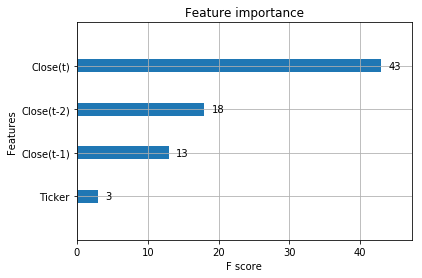

In [63]:
xgboost.plot_importance(xgb, height=0.3)

# KNeighbors

In [64]:
grids = sklearn.grid_search.ParameterGrid({
    'algorithm': ['ball_tree'],
    'n_neighbors': [9,13,15,17,19,23,25,27,29],
    'n_jobs':[-1],
    'p':[1,2],
    'weights': ['uniform', 'distance'],
})


max_acc = -1
best_param = {}
knn = None
for param in tqdm_notebook(grids):
    model = sklearn.neighbors.KNeighborsClassifier(**param)
    _=model.fit(x_train, np.squeeze(y_train.values))
    acc = sklearn.metrics.accuracy_score(np.squeeze(y_val.values), model.predict(x_val))
    if acc > max_acc:
        max_acc = deepcopy(acc)
        best_param = deepcopy(param)
        knn = deepcopy(model)
print('val_acc:', round(max_acc*100,2),'%')
best_param
knn
evaluator(knn, x_test, le)

HBox(children=(IntProgress(value=0, max=36), HTML(value='')))


val_acc: 66.24 %


{'algorithm': 'ball_tree',
 'n_jobs': -1,
 'n_neighbors': 9,
 'p': 2,
 'weights': 'distance'}

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
           weights='distance')

BANPU 	acc: 0.76
IRPC 	acc: 0.66
PTT 	acc: 0.69
BBL 	acc: 0.73
KBANK 	acc: 0.67
SCB 	acc: 0.71
AOT 	acc: 0.81
THAI 	acc: 0.60
CPF 	acc: 0.56
MINT 	acc: 0.62
TU 	acc: 0.67
SCC 	acc: 0.58
CPN 	acc: 0.59
CK 	acc: 0.55
CPALL 	acc: 0.54
HMPRO 	acc: 0.60
BDMS 	acc: 0.67
BH 	acc: 0.57
ADVANC 	acc: 0.70
JAS 	acc: 0.60
TRUE 	acc: 0.65
mean Accuracy: 0.6452


# Multivariate Bernoulli

In [67]:
grids = sklearn.grid_search.ParameterGrid({
    'alpha': [1.0]
})

max_acc = -1
best_param = {}
bay = None
for param in tqdm_notebook(grids):
    model = sklearn.naive_bayes.BernoulliNB(**param)
    _=model.fit(x_train, np.squeeze(y_train.values))
    acc = sklearn.metrics.accuracy_score(np.squeeze(y_val.values), model.predict(x_val))
    if acc > max_acc:
        max_acc = deepcopy(acc)
        best_param = deepcopy(param)
        bay = deepcopy(model)
print('val_acc:', round(max_acc*100,2),'%')
best_param
bay
evaluator(bay, x_test, le)

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


val_acc: 59.18 %


{'alpha': 1.0}

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

BANPU 	acc: 0.58
IRPC 	acc: 0.69
PTT 	acc: 0.56
BBL 	acc: 0.68
KBANK 	acc: 0.61
SCB 	acc: 0.61
AOT 	acc: 0.72
THAI 	acc: 0.52
CPF 	acc: 0.59
MINT 	acc: 0.61
TU 	acc: 0.57
SCC 	acc: 0.52
CPN 	acc: 0.56
CK 	acc: 0.60
CPALL 	acc: 0.69
HMPRO 	acc: 0.66
BDMS 	acc: 0.62
BH 	acc: 0.70
ADVANC 	acc: 0.58
JAS 	acc: 0.52
TRUE 	acc: 0.55
mean Accuracy: 0.6074


# Stacking Ensemble

In [68]:
stack = np.concatenate((
    dt.predict(x_val).reshape(-1,1),
    rf.predict(x_val).reshape(-1,1),
    ada.predict(x_val).reshape(-1,1),
    gb.predict(x_val).reshape(-1,1),
    xgb.predict(d_valid).reshape(-1,1),
    knn.predict(x_val).reshape(-1,1),
    bay.predict(x_val).reshape(-1,1),
), axis=1)

stack.shape

(2577, 7)

In [69]:
params = {
    'criterion':['friedman_mse'],
    'n_estimators':[50,75,100],
    'learning_rate':[0.1],
    'max_depth':[10,15,20,25],
    'random_state': [100],
    'presort':[True, False]
}

grid = sklearn.model_selection.GridSearchCV(
    ensemble.GradientBoostingClassifier(),
    params,
    n_jobs=-1
)
grid.fit(stack, np.squeeze(y_val.values))
grid.best_score_
grid.best_params_

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1], 'max_depth': [10, 15, 20, 25], 'presort': [True, False], 'n_estimators': [50, 75, 100], 'criterion': ['friedman_mse'], 'random_state': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

0.6554132712456344

{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 50,
 'presort': True,
 'random_state': 100}

In [70]:
gb_stack = ensemble.GradientBoostingRegressor(**grid.best_params_)
gb_stack.fit(stack, np.squeeze(y_val.values))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=10, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort=True, random_state=100,
             subsample=1.0, verbose=0, warm_start=False)

In [71]:
models = ['dt', 'rf', 'ada', 'gb', 'xgb', 'knn', 'bay']

In [72]:
for model, weight in zip(models, gb_stack.feature_importances_):
    print(round(weight,4), model)

0.0672 dt
0.0615 rf
0.1105 ada
0.0639 gb
0.2741 xgb
0.4227 knn
0.0 bay


In [73]:
ensemble_evaluator(
    x_test
)

BANPU 	acc: 0.75
IRPC 	acc: 0.74
PTT 	acc: 0.73
BBL 	acc: 0.74
KBANK 	acc: 0.71
SCB 	acc: 0.74
AOT 	acc: 0.85
THAI 	acc: 0.58
CPF 	acc: 0.55
MINT 	acc: 0.65
TU 	acc: 0.67
SCC 	acc: 0.62
CPN 	acc: 0.63
CK 	acc: 0.59
CPALL 	acc: 0.54
HMPRO 	acc: 0.62
BDMS 	acc: 0.68
BH 	acc: 0.62
ADVANC 	acc: 0.74
JAS 	acc: 0.61
TRUE 	acc: 0.62
mean Accuracy: 0.6657


In [11]:
def evaluator(clf, df_test, le, isXGB=False, isLSTM=False):
    ACCs = []
    for stock in target_stocks:
        x_tmp = df_test.loc[df_test['Ticker'] == le.transform([stock])[0]].copy()
        
        y_tmp = x_tmp[Horizon].values
        x_tmp = x_tmp.drop([Horizon], axis=1)
        
        if isXGB: 
            y_pred = clf.predict(xgboost.DMatrix(x_tmp))
            y_pred = np.where(y_pred>=0.5, 1, 0)
        else: y_pred = clf.predict(x_tmp.as_matrix())
        
        acc = sklearn.metrics.accuracy_score(y_tmp, y_pred)
        print(stock, "\tacc: %.2f" % (acc))
        ACCs.append(acc)
    
    print('mean Accuracy:', round(np.mean(ACCs),4))

def ensemble_evaluator(df_test):
    ACCs = []
    for stock in target_stocks:
        x_tmp = df_test.loc[df_test['Ticker'] == le.transform([stock])[0]].copy()
        
        y_tmp = x_tmp[Horizon].values
        x_tmp = x_tmp.drop([Horizon], axis=1)
        
        # Prediction
        
        y_dt = dt.predict(x_tmp.as_matrix())
        y_rf = rf.predict(x_tmp.as_matrix())
        y_ada = ada.predict(x_tmp.as_matrix())
        y_gb = gb.predict(x_tmp.as_matrix())
        
        y_xgb = xgb.predict(xgboost.DMatrix(x_tmp))
        y_xgb = np.where(y_xgb>=0.5, 1, 0)

        y_knn = knn.predict(x_tmp.as_matrix())
        y_bay = bay.predict(x_tmp.as_matrix())

#         y_pred = (y_dt+y_rf+y_ada+y_gb+y_xgb+y_knn+y_bay)/7
        
        y_all = np.concatenate((
            y_dt.reshape(-1,1),
            y_rf.reshape(-1,1),
            y_ada.reshape(-1,1),
            y_gb.reshape(-1,1),
            y_xgb.reshape(-1,1),
            y_knn.reshape(-1,1),
            y_bay.reshape(-1,1)
        ), axis=1)
        y_pred = np.zeros((y_all.shape[0],1))
        for i in range(y_all.shape[1]):
            y_pred += y_all[:,i].reshape(-1,1)*gb_stack.feature_importances_[i]
        y_pred = np.squeeze(y_pred)
        y_pred = np.where(y_pred>=0.5, 1, 0)

        acc = sklearn.metrics.accuracy_score(y_tmp, y_pred)
        print(stock, "\tacc: %.2f" % (acc))
        ACCs.append(acc)
    
    print('mean Accuracy:', round(np.mean(ACCs),4))